In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%load_ext jupyternotify
%load_ext autoreload
%autoreload 2
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime
import random 
import sys
from ecological_fairness import * 
import pandas as pd
import glob
from scipy.spatial import Delaunay
import numpy as np
from scipy.spatial import ConvexHull, convex_hull_plot_2d

<IPython.core.display.Javascript object>

In [3]:
def get_dem_disp_obs_outcomes_multi_race_over_LCs(Y, n_as, mu_scalar, p_az,
    p_yz,  Z, LCs,ind_mu, quiet=True, smoothing=None, smoothing1d=False, direction = 'max', save = True):
    ress__ = [None] * len(LCs)
    for ind,lc in enumerate(LCs):
        ress__[ind] = get_dem_disp_obs_outcomes_multi_race(Y, n_as, mu_scalar, p_az, p_yz,  Z, lc, quiet, smoothing, smoothing1d, direction)
        pickle.dump({'res': ress__[ind], 'mu_scalar':mu_scalar}, open('out/countyincome/output-'+str(ind_mu)+'-'+'lc' + str(lc) +'-' +datetime.now().strftime('%Y-%m-%d-%H-%M-%S')+'.pkl', 'wb'))
    pickle.dump({'res': ress__, 'mu_scalar':mu_scalar}, open('out/output-'+str(ind_mu)+'-'+datetime.now().strftime('%Y-%m-%d-%H-%M-%S')+'.pkl', 'wb'))
    return ress__

def get_DD_multi_race_caller(Y, n_as, mu_scalar, p_az, p_yz,  Z, lc, ind, quiet=True, smoothing=None, smoothing1d=False,direction = 'max', stump = 'hmda', save = True):
    res = get_dem_disp_obs_outcomes_multi_race(Y, n_as, mu_scalar, p_az, p_yz,  Z, lc, quiet, smoothing, smoothing1d, direction)
    pickle.dump({'res': res, 'mu_scalar':mu_scalar, 'lc':lc}, open('out/'+stump+'/output-'+str(ind)+'-lc-'+str(lc)+'-'+datetime.now().strftime('%Y-%m-%d-%H-%M-%S')+'.pkl', 'wb'))
    return res


def select_name(lip, lip_list_whole, name_list):
    return [name_list[i] for i in range(len(lip_list_whole)) if (lip == lip_list_whole[i])]


def get_disps(w_y1, w_y0, n_as, y, p_as):
    n = len(y)
    return [ 1.0/n * ( np.dot(w_y1[0,:],y)/p_as[0] - np.dot(w_y1[a,:],y)/p_as[a] ) for a in range(n_as)[1:] ]


def compute_disparity_from_res(res, n_as, Y, p_as):
    if (~np.isnan(res[0])):
        return get_disps(res[1], res[2], n_as, Y, p_as)
    else:
        return [np.nan, np.nan]
    
def parse_name(directory, N_LCs):
    name_list = glob.glob(directory + "/*")
    split_name = [name.split('-') for name in name_list]
    lip_list_whole = [s[3] for s in split_name]
    lip_list = lip_list_whole[0:N_LCs]
    return lip_list, lip_list_whole, name_list

def compile_disparity(lip_list, lip_list_whole, name_list, n_as, Y, p_as):
    dd = {lip:None for lip in lip_list}
    for lip in lip_list:
        print lip 
        files = select_name(lip, lip_list_whole, name_list)
        disparity = np.zeros((len(files), 2))
        for ind in range(len(files)):
            disps_temp = pickle.load(open(files[ind],'rb')) 
            mu_scalar = disps_temp['mu_scalar']
            res = disps_temp['res']
            disparity[ind, :] = compute_disparity_from_res(res, n_as, Y, p_as)
        dd[lip] = disparity
    return dd

def compute_nuisance_components(data_path):
    hmda_ = pd.read_csv(data_path)
    Y = hmda_['outcome']
    p_yz_inc = hmda_['yhat1']# loan conditional on income
    p_az_inc = hmda_[['White', 'API','Black']]
    p_as = (p_az_inc.sum(axis=0)/p_az_inc.shape[0])
    p_as
    p_as2 = [0]*3
    p_as2[0] = p_as['White']
    p_as2[1] = p_as['API']
    p_as2[2] = p_as['Black']
    p_as = p_as2 
    p_as
    
    return (Y, p_as)

def check_feasibility(disparity):
    feasible = []
    infeasible = []
    for lp in lip_list:
        if np.isnan(disparity[lp][0][0]):
            infeasible.append(lp)
        else:
            feasible.append(lp)

    return infeasible, feasible 

    
n_as = 3


## Helper functions

In [7]:
def get_tpr_from_proxy(proxy,y=1): 
    white_tpr = sum((proxy['Yhat']==y)&(proxy['Y']==y)&(proxy['race']=='White.'))*1.0/sum((proxy['Y']==y)&(proxy['race']=='White.'))
    asian_tpr = sum((proxy['Yhat']==y)&(proxy['Y']==y)&(proxy['race']=='Asian.'))*1.0/sum((proxy['Y']==y)&(proxy['race']=='Asian.'))
    black_tpr = sum((proxy['Yhat']==y)&(proxy['Y']==y)&(proxy['race']=='Black.'))*1.0/sum((proxy['Y']==y)&(proxy['race']=='Black.'))
    return [white_tpr, asian_tpr, black_tpr]

''' Plot convex hull of disparities 
'''
def plot_disp_truth(disparities, truth,title=None,xlimylim=[(0,1),(-0.5,0.5)],newfig_bool=True,newfig=True, label = ''): 
    if newfig_bool:
        fig = plt.figure(figsize=(3,3))
    else: 
        fig = newfig
    ax = fig.add_subplot('111', aspect='equal') 
    truth = [white_tpr - asian_tpr, white_tpr - black_tpr]
    ax.plot(truth[0], truth[1], 'r*', markersize = 10)

    xlim, ylim = xlimylim#(-1, 1), (-1, 1)
    ax.set_xlim(xlim)# 
    ax.set_ylim(ylim)
    plt.tight_layout()
    plt.xlabel("TPR Disparity: White vs Asian")
    plt.ylabel("TPR Disparity: White vs Black")
    plt.title(title)
    
    ch = ConvexHull(disparities)
    plt.scatter(disparities[:, 0], disparities[:, 1], s = 50, label = label)
    for simplex in ch.simplices:
        plt.plot(disparities[simplex, 0], disparities[simplex, 1], 'k--')
    plt.legend()
    
''' Compute pairwise disparities given tpr, tnr data for all groups
'''
def get_disps_fm_wfn(warfarin_, Y, Yhat, joints, p_az, type='tpr'):
    disparities = np.zeros([len(warfarin_),2])
    for ind in range(len(warfarin_)):
        this_res = warfarin_[ind]
        [tpr,tnr] = get_tpr_tnr_from_weights_mult_a(this_res[1], this_res[2], Y, Yhat, joints, p_az)
        if type=='tpr':
            disparities[ind,:] = [ tpr[0] - tpr[1], tpr[0] - tpr[2]] 
        else:
            disparities[ind,:] = [ tnr[0] - tnr[1], tnr[0] - tnr[2]] 
    return disparities



In [ ]:
[white_tpr, asian_tpr, black_tpr] = get_tpr_from_proxy(gen_proxy,1)



## Load proxy variables and compute ground truth disparity

In [4]:
import pandas as pd
gen_proxy = pd.read_csv('genetic_as_proxy.csv')
medgen_proxy = pd.read_csv('medicine_genetic_as_proxy.csv')
med_proxy = pd.read_csv('medicine_as_proxy.csv')

white_tpr = sum((medgen_proxy['Yhat']==1)&(medgen_proxy['Y']==1)&(medgen_proxy['race']=='White.'))*1.0/sum((medgen_proxy['Y']==1)&(medgen_proxy['race']=='White.'))
print 'white tpr', white_tpr
asian_tpr = sum((medgen_proxy['Yhat']==1)&(medgen_proxy['Y']==1)&(medgen_proxy['race']=='Asian.'))*1.0/sum((medgen_proxy['Y']==1)&(medgen_proxy['race']=='Asian.'))
print 'asian tpr', asian_tpr
black_tpr = sum((medgen_proxy['Yhat']==1)&(medgen_proxy['Y']==1)&(medgen_proxy['race']=='Black.'))*1.0/sum((medgen_proxy['Y']==1)&(medgen_proxy['race']=='Black.'))
print 'black tpr', black_tpr

mixed_tpr = sum((medgen_proxy['Yhat']==1)&(medgen_proxy['Y']==1)&(medgen_proxy['race']!='White.'))*1.0/sum((medgen_proxy['Y']==1)&(medgen_proxy['race']!='White.'))
print mixed_tpr


medgen_proxy
Y = medgen_proxy['Y']
Yhat = medgen_proxy['Yhat']
p_az = medgen_proxy['white_prob'] 
# first do white against nonwhite

joints = [ medgen_proxy['py1yhat1'], medgen_proxy['py0yhat1'], medgen_proxy['py1yhat0'], medgen_proxy['py0yhat0'] ]

# get feasible ranges 
p_az = medgen_proxy['asian_prob'] 
proxies = ['medical and gen.', 'med', 'gen']

white tpr 0.765151515152
asian tpr 0.401408450704
black tpr 0.87044534413
0.699228791774


## Plot 
Load warfarin disparities 

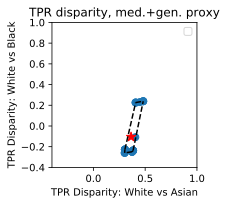

In [5]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot('111', aspect='equal') 
truth = [white_tpr - asian_tpr, white_tpr - black_tpr]
ax.plot(truth[0], truth[1], 'r*', markersize = 10)

# disps: [[min_tpr, max_tpr],[min_tnr, max_tnr]]

disps = pickle.load(open('save_out/warfarin-tpr-disps.p', 'rb'))

    
xlim, ylim = ((-0.4,1),(-0.4,1))#(0,1),(-0.5,0.5)
#(0.2, 0.6),(-0.3, 0.3)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.xlabel("TPR Disparity: White vs Asian")
plt.ylabel("TPR Disparity: White vs Black")
# with 25 betas d
res = pickle.load(open('save_out/warfarintprs-more-disps.pkl', 'rb'))
disparities = res['disps']
ch = ConvexHull(disparities)
plt.scatter(disparities[:, 0], disparities[:, 1], s = 50)
for simplex in ch.simplices:
    plt.plot(disparities[simplex, 0], disparities[simplex, 1], 'k--')
plt.tight_layout()
plt.title('TPR disparity, med.+gen. proxy')
# plt.savefig('writing/slides_figure/warfarin-medgen-TPR-suppfn.pdf',bbox_inches='tight')
box = pickle.load(open('save_out/warfarin-tpr-disps.p', 'rb'))
plt.legend()

## Plot disparities for other proxies

Genetic proxy

<Figure size 432x288 with 0 Axes>

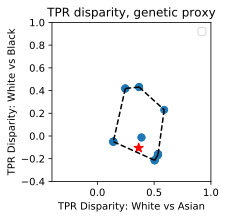

In [13]:
proxy = gen_proxy
joints = [ proxy['py1yhat1'], proxy['py0yhat1'], proxy['py1yhat0'], proxy['py0yhat0'] ]
p_az = proxy[['white_prob','asian_prob','black_prob']].values
warfarin_tprs_gen = pickle.load(open('save_out/warfarintprs-gen_proxy.pkl','rb'))
[white_tpr, asian_tpr, black_tpr] = get_tpr_from_proxy(gen_proxy)
tprs_gen_disparities = get_disps_fm_wfn(warfarin_tprs_gen, Y, Yhat, joints, p_az)

plt.tight_layout()
plot_disp_truth(tprs_gen_disparities, [white_tpr - asian_tpr,white_tpr - black_tpr],xlimylim = ((-0.4,1),(-0.4,1)), title='TPR disparity, genetic proxy')
# plt.savefig('writing/slides_figure/tpr-genetic-proxy.pdf',bbox_inches='tight')

Medicine proxy

<Figure size 216x216 with 0 Axes>

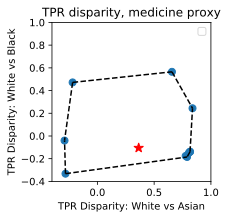

In [12]:
warfarin_tprs = pickle.load(open('saveout/warfarintprsmed_proxy.pkl','rb'))
proxy = med_proxy
joints = [ proxy['py1yhat1'], proxy['py0yhat1'], proxy['py1yhat0'], proxy['py0yhat0'] ]
Y = proxy['Y']
Yhat = proxy['Yhat']
p_az = proxy[['white_prob','asian_prob','black_prob']].values
tprs_med_disparities = get_disps_fm_wfn(warfarin_tprs, Y, Yhat, joints, p_az,type='tpr')

plt.figure(figsize=(3,3))
plt.tight_layout()
plot_disp_truth(tprs_med_disparities, [white_tpr - asian_tpr,white_tpr - black_tpr], xlimylim = ((-0.4,1),(-0.4,1)), title='TPR disparity, medicine proxy')
# plt.savefig('writing/slides_figure/tpr-med-proxy.pdf',bbox_inches='tight')